# Denoising with a learned DNN prior

We consider the classical image or data denoising problem, where the goal is to remove zero-mean white Gaussian noise from a given image or data point. In more detail, our goal is to obtain an estimate of a vector $y_0 \in \mathbb R^n$ from the noisy observation
$$
y = y_0 + \eta, 
$$
where $\eta$ is zero-mean Gaussian noise with covariance matrix $\sigma^2/n I$, and $y_0$ lies in the range of the generator, i.e., $y_0=G(x_0)$.

We consider the following two-step denoising algorithm:
1. Obtaine an estimate $\hat x$ of the latent representation by minimizing the empirical loss
$$
f(x) = \|G(x) - y_0\|_2^2
$$
using gradient descent.
2. Obtain an estimate of the image as $\hat y = G(\hat x)$.

We obtain G as the encoder of a learned autoencoder.

In [1]:
import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

import random
import numpy as np
import collections

## Get data

In [2]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test  = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

batch_size = 1
train_set = [ex for ex in torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True)]
test_set = [ex for ex in torch.utils.data.DataLoader(dataset=mnist_test,batch_size=batch_size,shuffle=True)]

# construct training and test set only consisting of twos
def extract_nu(dset,nu):
    eset = []
    for image,label in train_set:
        if label.numpy() == nu:
            eset.append((image,label))
    return eset
train_twos = extract_nu(train_set,2)
test_twos = extract_nu(test_set,2)

## Specification of the autoencoder

Next, we specify the encoder and decoder parameterized by lengthbottleneck:
- Encoder: 784 neurons -> 400 neurons -> lengthbottleneck neurons
- Decoder: lengthbottleneck neurons -> 400 neurons -> 784 neurons

In [3]:
class Encoder(nn.Module):
    def __init__(self,lenbottleneck = 20):
        super(Encoder,self).__init__()
        self.fc1 = nn.Linear(28*28, 20*20)
        self.fc2 = nn.Linear(20*20,lenbottleneck)                
    def forward(self,x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self,lenbottleneck = 20):
        super(Decoder,self).__init__()
        self.fc1 = nn.Linear(lenbottleneck,20*20)
        self.fc2 = nn.Linear(20*20,28*28)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(28,28)
        return x

In [4]:
def train(encoder,decoder,trainset,learning_rate = 0.001,epoch = 10):
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    loss_func = nn.MSELoss() # mean square loss after the decoder 
    print("learning_rate: ",learning_rate)
    optimizer = torch.optim.SGD(parameters, lr=learning_rate)
    ctr = 0
    for i in range(epoch):
        print("at epoch ", i + 1 , "/", epoch)
        for (image,label) in trainset:
            ctr += 1
            image = Variable(image)
            optimizer.zero_grad()
            output = encoder(image)
            output = decoder(output)
            loss = loss_func(output,image)
            loss.backward()
            optimizer.step()
    print("trained in ",ctr," iterations")
    return encoder, decoder

## Training autoencoders

In [5]:
# train autoencoder for all digits
K = 10
encoder10 = Encoder(K)
decoder10 = Decoder(K)
encoder,decoder = train(encoder10,decoder10,train_set[:10000],1.0)

learning_rate:  1.0
at epoch  1 / 10
at epoch  2 / 10
at epoch  3 / 10
at epoch  4 / 10
at epoch  5 / 10
at epoch  6 / 10
at epoch  7 / 10
at epoch  8 / 10
at epoch  9 / 10
at epoch  10 / 10
trained in  100000  iterations


### Plot the weight distribution

(4000,)


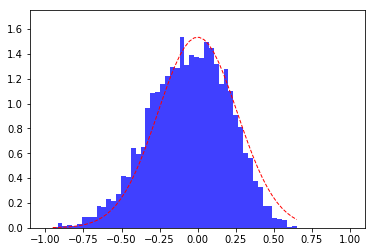

In [6]:
a = decoder.fc1.weight.data.numpy()
a = np.ndarray.flatten(a)
print(a.shape)
import matplotlib.mlab as mlab
n, bins, patches = plt.hist(a, 50, normed=1, facecolor='blue', alpha=0.75)

# add a 'best fit' line
mu, sigma = 0, 0.26
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.axis([-1.1, 1.1, 0, 1.75])

#plt.hist(a, normed=True, bins=1000)

plt.show()

In [7]:
# train autoencoder for all digits
K = 20
encoder20 = Encoder(K)
decoder20 = Decoder(K)
encoder20,decoder20 = train(encoder20,decoder20,train_set[:10000],1.0)

learning_rate:  1.0
at epoch  1 / 10
at epoch  2 / 10
at epoch  3 / 10
at epoch  4 / 10
at epoch  5 / 10
at epoch  6 / 10
at epoch  7 / 10
at epoch  8 / 10
at epoch  9 / 10
at epoch  10 / 10
trained in  100000  iterations


In [8]:
# given two lists of images as np-arrays, plot them as a row
def plot_images(top,bottom):
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
    for images, row in zip([top, bottom], axes):
        for img, ax in zip(images, row):
            ax.imshow(img, cmap='Greys_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0.1)
    return fig

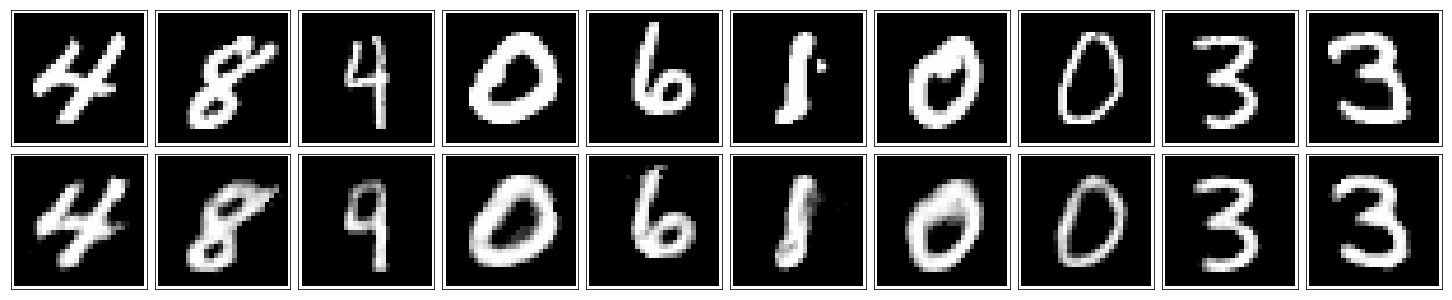

In [9]:
# Check output of autoencoder: print one input/output pairs
in_imgs = []
out_imgs = []
numprint = 10
for i,(img,label) in enumerate(test_set):
    if i >= numprint:
        break
    out_img = decoder20(encoder20(Variable(img)))
    in_imgs += [img[0][0].numpy()] # img is 1x1x28x28 tensor
    out_img.data.clamp_(0, 1)
    out_imgs += [out_img.data.numpy()]

fig = plot_images(in_imgs,out_imgs)

## Denoising with trained decoder

In [10]:
# function to estimate the latent representation
def invert_prior(net, noisy_image,latent_param,learning_rate=0.1, num_steps=500):
    optimizer = torch.optim.SGD([latent_param], lr=learning_rate) 
    iter_idx = 0
    while iter_idx <= num_steps:
        # correct the values of updated input signal
        optimizer.zero_grad()
        output = net(latent_param)
        loss = F.mse_loss(output, noisy_image, size_average=False)
        loss.backward()
        optimizer.step()
        iter_idx += 1    
    return latent_param

# denoise by recovering estimating a latent representation and passing that through the decoder
def denoise(net,noisy_image,K,learning_rate=0.1):
    rec_rep = Variable(torch.randn(K), requires_grad=True)
    rec_rep = invert_prior(net, noisy_image, rec_rep,learning_rate)
    if(sum(rec_rep.data.numpy()*rec_rep.data.numpy()) > 10000):
        print("stepsize to large?")
    return net(rec_rep)

## Visualize denoising performance

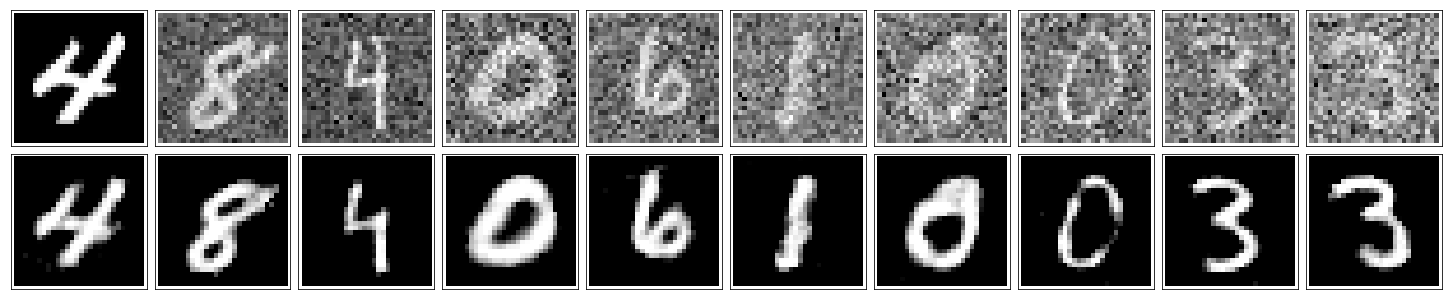

In [11]:
K = 20
Sigmas = [0.3*i for i in range(10)] # noise variances
noisy_imgs = []
rec_imgs = []
for (img,label),sigma in zip(test_set[:len(Sigmas)],Sigmas):
    img = img[0][0]
    noise = np.sqrt(sigma)*torch.norm(img)/np.sqrt(28*28)*torch.randn(28, 28)
    noisy_img = img + noise
    rec_img = denoise(decoder20,Variable(noisy_img),K,0.1)
    rec_img.data.clamp_(0, 1)
    noisy_imgs += [noisy_img.numpy()]
    rec_imgs += [rec_img.data.numpy()]

# plot and save to file
fig = plot_images(noisy_imgs,rec_imgs)
fig.savefig("denoising_ex_0.1.png")

## Generate plots for paper

In [12]:
N = 782
def estimate_MSE(decoder,dataset,Sigmas,K,numit=1):
    MSEs = np.zeros(len(Sigmas))
    for i,sigma in enumerate(Sigmas):
        for (img,label) in test_twos[:numit]:
            img = img[0]
            noise = np.sqrt(sigma)*torch.norm(img)/np.sqrt(N)*torch.randn(1, 28, 28)
            noisy_img = img + noise
            rec_img = denoise(decoder,Variable(noisy_img),K)
            rec_img.data.clamp_(0, 1)
            MSErec = torch.norm( rec_img.data.numpy() - img[0] )**2 / torch.norm(img)**2
            MSEs[i] += MSErec/numit
    return MSEs

numit=100
Sigmas = [0.3*i for i in range(22)] # noise variances

K = 10
MSEs10 = estimate_MSE(decoder10,test_set,Sigmas,K,numit)

K = 20
MSEs20 = estimate_MSE(decoder20,test_set,Sigmas,K,numit)

Slope of MSE10: 0.03319207866007233
Slope of MSE20: 0.05402469204793347


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


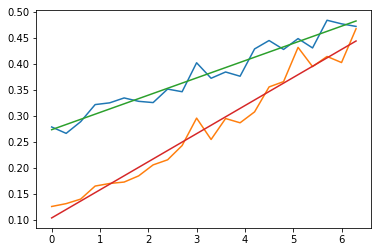

In [13]:
# least squares fit
a,b = np.linalg.lstsq(np.vstack([Sigmas, np.ones(len(Sigmas))]).T,MSEs10)[0]
print("Slope of MSE10:", a)
MSEs10fit = b + np.array(Sigmas)*a

# least squares fit
a,b = np.linalg.lstsq(np.vstack([Sigmas, np.ones(len(Sigmas))]).T,MSEs20)[0]
print("Slope of MSE20:", a)
MSEs20fit = b + np.array(Sigmas)*a


plt.plot(Sigmas,MSEs10)
plt.plot(Sigmas,MSEs20)
plt.plot(Sigmas,MSEs10fit)
plt.plot(Sigmas,MSEs20fit)
plt.show()

mtx = np.array([Sigmas, MSEs10, MSEs20, MSEs10fit, MSEs20fit])
np.savetxt("./denoise_learned.dat", mtx.T , delimiter='\t')
